# Infer ***lipid body*** - part 9️⃣

--------------

## OBJECTIVE: ✅ Infer sub-cellular component ***lipid body***  in order to understand interactome 



Dependencies:
The  ***lipid body***  inference rely on the cytosol mask.



## IMPORTS

In [11]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict

import numpy as np
import scipy

# TODO:  prune the imports.. this is the big set for almost all organelles
# # function for core algorithm
from scipy import ndimage as ndi
import aicssegmentation
from aicssegmentation.core.seg_dot import dot_3d_wrapper, dot_slice_by_slice, dot_2d_slice_by_slice_wrapper, dot_3d
from aicssegmentation.core.pre_processing_utils import ( intensity_normalization, 
                                                         image_smoothing_gaussian_3d,  
                                                         image_smoothing_gaussian_slice_by_slice,
                                                         edge_preserving_smoothing_3d )
from aicssegmentation.core.utils import topology_preserving_thinning, size_filter
from aicssegmentation.core.MO_threshold import MO
from aicssegmentation.core.utils import hole_filling
from aicssegmentation.core.vessel import filament_2d_wrapper, vesselnessSliceBySlice
from aicssegmentation.core.output_utils import   save_segmentation,  generate_segmentation_contour
                                                 
from skimage import filters
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects, binary_closing, ball , dilation, remove_small_holes   # function for post-processing (size filter)
from skimage.measure import label

# # package for io 
from aicsimageio import AICSImage

import napari

### import local python functions in ../infer_subc_2d
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))

from infer_subc_2d.utils.file_io import (read_czi_image, 
                                                                    list_image_files, 
                                                                    export_ome_tiff, 
                                                                    etree_to_dict, 
                                                                    save_parameters, 
                                                                    load_parameters, 
                                                                    export_ndarray)
from infer_subc_2d.utils.img import *
from infer_subc_2d.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROXI_CH ,
                                                                    ER_CH ,
                                                                    LIPID_CH ,
                                                                    RESIDUAL_CH )        
                                                                    
from infer_subc_2d.organelles.soma import infer_soma
from infer_subc_2d.organelles.nuclei import infer_nuclei
from infer_subc_2d.organelles.cytosol import infer_cytosol

%load_ext autoreload
%autoreload 2

test_img_n = 5

ImportError: cannot import name 'infer_nuclei' from 'infer_subc_2d.organelles.nuclei' (/Users/ahenrie/Projects/Imaging/infer-subc-2D/infer_subc_2d/organelles/nuclei.py)

# IMAGE PROCESSING Objective 9️⃣:  infer ***lipid body*** 
> Back to  [OUTLINE: Objectives 9️⃣](00_pipeline_setup.ipynb#summary-of-objectives)

## summary 

NOTE:  consider using [Fibrillarin](https://www.allencell.org/cell-observations/category/fibrillarin) (nucleous marker) workflow from AllenCell.  playground_spotty.ipynb  or maybe [centrin](https://www.allencell.org/cell-observations/category/centrin)


Not a good thing to follow from  the Allen Cell Segmenter procedure, but doing more aggressive contrast scaling than their prescribed contrast scaling.

### steps

INPUT
- ch 7
- cytosol mask


PRE-PROCESSING
- rescale 
-  median, window 2
-  
CORE-PROCESSING
   - "robust background" 2 STD

POST-PROCESSING
  - n/a

OUTPUT
- object BD






------------------------
# LOAD RAW IMAGE DATA
Identify path to _raw_ image data and load our example image


In [12]:
data_root_path = Path(os.path.expanduser("~")) / "Projects/Imaging/data"

# linearly unmixed ".czi" files are here
data_path = data_root_path / "raw"
im_type = ".czi"

# get the list of all files
img_file_list = list_image_files(data_path,im_type)
test_img_name = img_file_list[test_img_n]

img_data,meta_dict = read_czi_image(test_img_name)

# get some top-level info about the RAW data
channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']


/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/ome_types/_convenience.py:105: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


## CHOOZE Z-SLICE

Lets find the slice with the most overall intensity...

In [13]:
ch_to_agg = ( LYSO_CH ,
                        MITO_CH ,
                        GOLGI_CH ,
                        PEROXI_CH ,
                        ER_CH ,
                        LIPID_CH )
                            
nuc_ch = NUC_CH
optimal_Z = find_optimal_Z(img_data, nuc_ch, ch_to_agg) 



Now get the single "optimal" slice of all our organelle channels....

In [14]:
img_2D = img_data[:,[optimal_Z],:,:].copy()

## Collect the ***cytosol*** mask

i.e. inferred soma, nuclei and cytosol objects
(takes < 1 sec)

In [15]:

soma_mask =  infer_soma(img_2D) 
nuclei_object =  infer_nuclei(img_2D, soma_mask) 
cytosol_mask =  infer_cytosol( nuclei_object,soma_mask) 


## Build  ***lipid body***  specific inference workflow



### INPUT

In [16]:
###################
# INPUT
###################
raw_er   = img_2D[LIPID_CH].copy()


### PRE-PROCESSING

In [17]:
###################
# PRE_PROCESSING
###################
struct_img = min_max_intensity_normalization( raw_er)

med_filter_size = 2   
struct_img = median_filter_slice_by_slice( 
                                                                struct_img,
                                                                size=med_filter_size  )

gaussian_smoothing_sigma = 1.34
gaussian_smoothing_truncate_range = 3.0
struct_img = image_smoothing_gaussian_slice_by_slice(   struct_img,
                                                                                                    sigma=gaussian_smoothing_sigma,
                                                                                                    truncate_range = gaussian_smoothing_truncate_range
                                                                                                )


### CORE PROCESSING

In [33]:

###################
# CORE_PROCESSING
###################

threshold_factor = 0.99 #from cellProfiler
thresh_min = .5
thresh_max = 1.
otsu_thresholded = apply_threshold(struct_img, method= "otsu", threshold_factor=threshold_factor, thresh_min=thresh_min, thresh_max=thresh_max)


### POST-PROCESSING

In [31]:

###################
# POST_PROCESSING
###################
# # wrapper to remoce_small_objects
hole_min = 0
hole_max = 2.5
bw = hole_filling(otsu_thresholded, hole_min=hole_min**2, hole_max=hole_max**2, fill_2d=True)

struct_obj = apply_mask(bw, cytosol_mask)

small_object_max = 4

struct_obj = size_filter_2D(struct_obj, # wrapper to remove_small_objects which can do slice by slice
                                                         min_size= small_object_max ** 2, 
                                                         connectivity=1)


lipid_object = struct_obj
lipid_labels = label( lipid_object   )


#### Visualize with `napari`
Visualize the first-pass segmentation and labeling with `napari`.

In [27]:

viewer = napari.view_image(
    lipid_object,
    scale=scale
)



NameError: name 'structure_img_smooth' is not defined

In [29]:

viewer.scale_bar.visible = True
viewer.add_image(
    struct_img,
    scale=scale
)

viewer.add_labels(
    lipid_labels,
    scale=scale
)

<Labels layer 'lipid_labels' at 0x174457820>

In [32]:
viewer.add_image(
    lipid_object,
    scale=scale
)



<Image layer 'lipid_object [1]' at 0x17f05b8b0>

### Collect into a single `infer_lipid_body` function

In [36]:
##########################
#  infer_endoplasmic_reticulum
##########################
def _infer_lipid_body(in_img:  np.ndarray, cytosol_mask:  np.ndarray) -> np.ndarray:
    """
    Procedure to infer peroxisome from linearly unmixed input.

    Parameters:
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels

    cytosol_mask: np.ndarray
        mask of cytosol
 
    Returns:
    -------------
    peroxi_object
        mask defined extent of peroxisome object
    """
    in_img   = img_2D[LIPID_CH].copy()

    ###################
    # PRE_PROCESSING
    ###################                         
    struct_img = min_max_intensity_normalization( struct_img )

    med_filter_size = 2   
    struct_img = median_filter_slice_by_slice( 
                                                                    struct_img,
                                                                    size=med_filter_size  )

    gaussian_smoothing_sigma = 1.34
    gaussian_smoothing_truncate_range = 3.0
    struct_img = image_smoothing_gaussian_slice_by_slice(   struct_img,
                                                                                                        sigma=gaussian_smoothing_sigma,
                                                                                                        truncate_range = gaussian_smoothing_truncate_range
                                                                                                    )



   ###################
    # CORE_PROCESSING
    ###################

    threshold_factor = 0.99 #from cellProfiler
    thresh_min = .5
    thresh_max = 1.
    bw = apply_threshold(struct_img, method= "otsu", threshold_factor=threshold_factor, thresh_min=thresh_min, thresh_max=thresh_max)

    ###################
    # POST_PROCESSING
    ###################
    # 2D cleaning
    hole_min = 0
    hole_max = 2.5
    struct_obj = hole_filling(bw, hole_min=hole_min**2, hole_max=hole_max**2, fill_2d=True)

    struct_obj = apply_mask(struct_obj, cytosol_mask)

    small_object_max = 4
    struct_obj = size_filter_2D(struct_obj, # wrapper to remove_small_objects which can do slice by slice
                                                            min_size= small_object_max ** 2, 
                                                            connectivity=1)

    return struct_obj


[autoreload of infer_subc_2d.organelles.lipid failed: Traceback (most recent call last):
  File "/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/opt/anaconda3/envs/napariNEW/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/opt/anaconda3/envs/napariNEW/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/ahenrie/Projects/Imaging/infer-subc-2D/infer_subc_2d/organelles/lipid.py", line 20, in <module>
    def _infer_lipid_body(in_img: np.ndarray, cytosol_mask: np.ndarray) -> np.ndarray:
NameError: name 'np' is not defined
]


# TEST  `infer_lipid_body` function

In [38]:

_lipid_obj =  _infer_lipid_body(img_2D, cytosol_mask) 

In [39]:
from infer_subc_2d.organelles.er import infer_endoplasmic_reticulum

lipid_obj =  infer_lipid_body(img_2D, cytosol_mask) 

In [40]:

viewer.add_image(
    _lipid_obj,
    scale=scale
)

viewer.add_image(
    lipid_obj,
    scale=scale
)
viewer.add_labels(
    label(lipid_obj),
    scale=scale
)

<Labels layer 'Labels' at 0x17f282fd0>

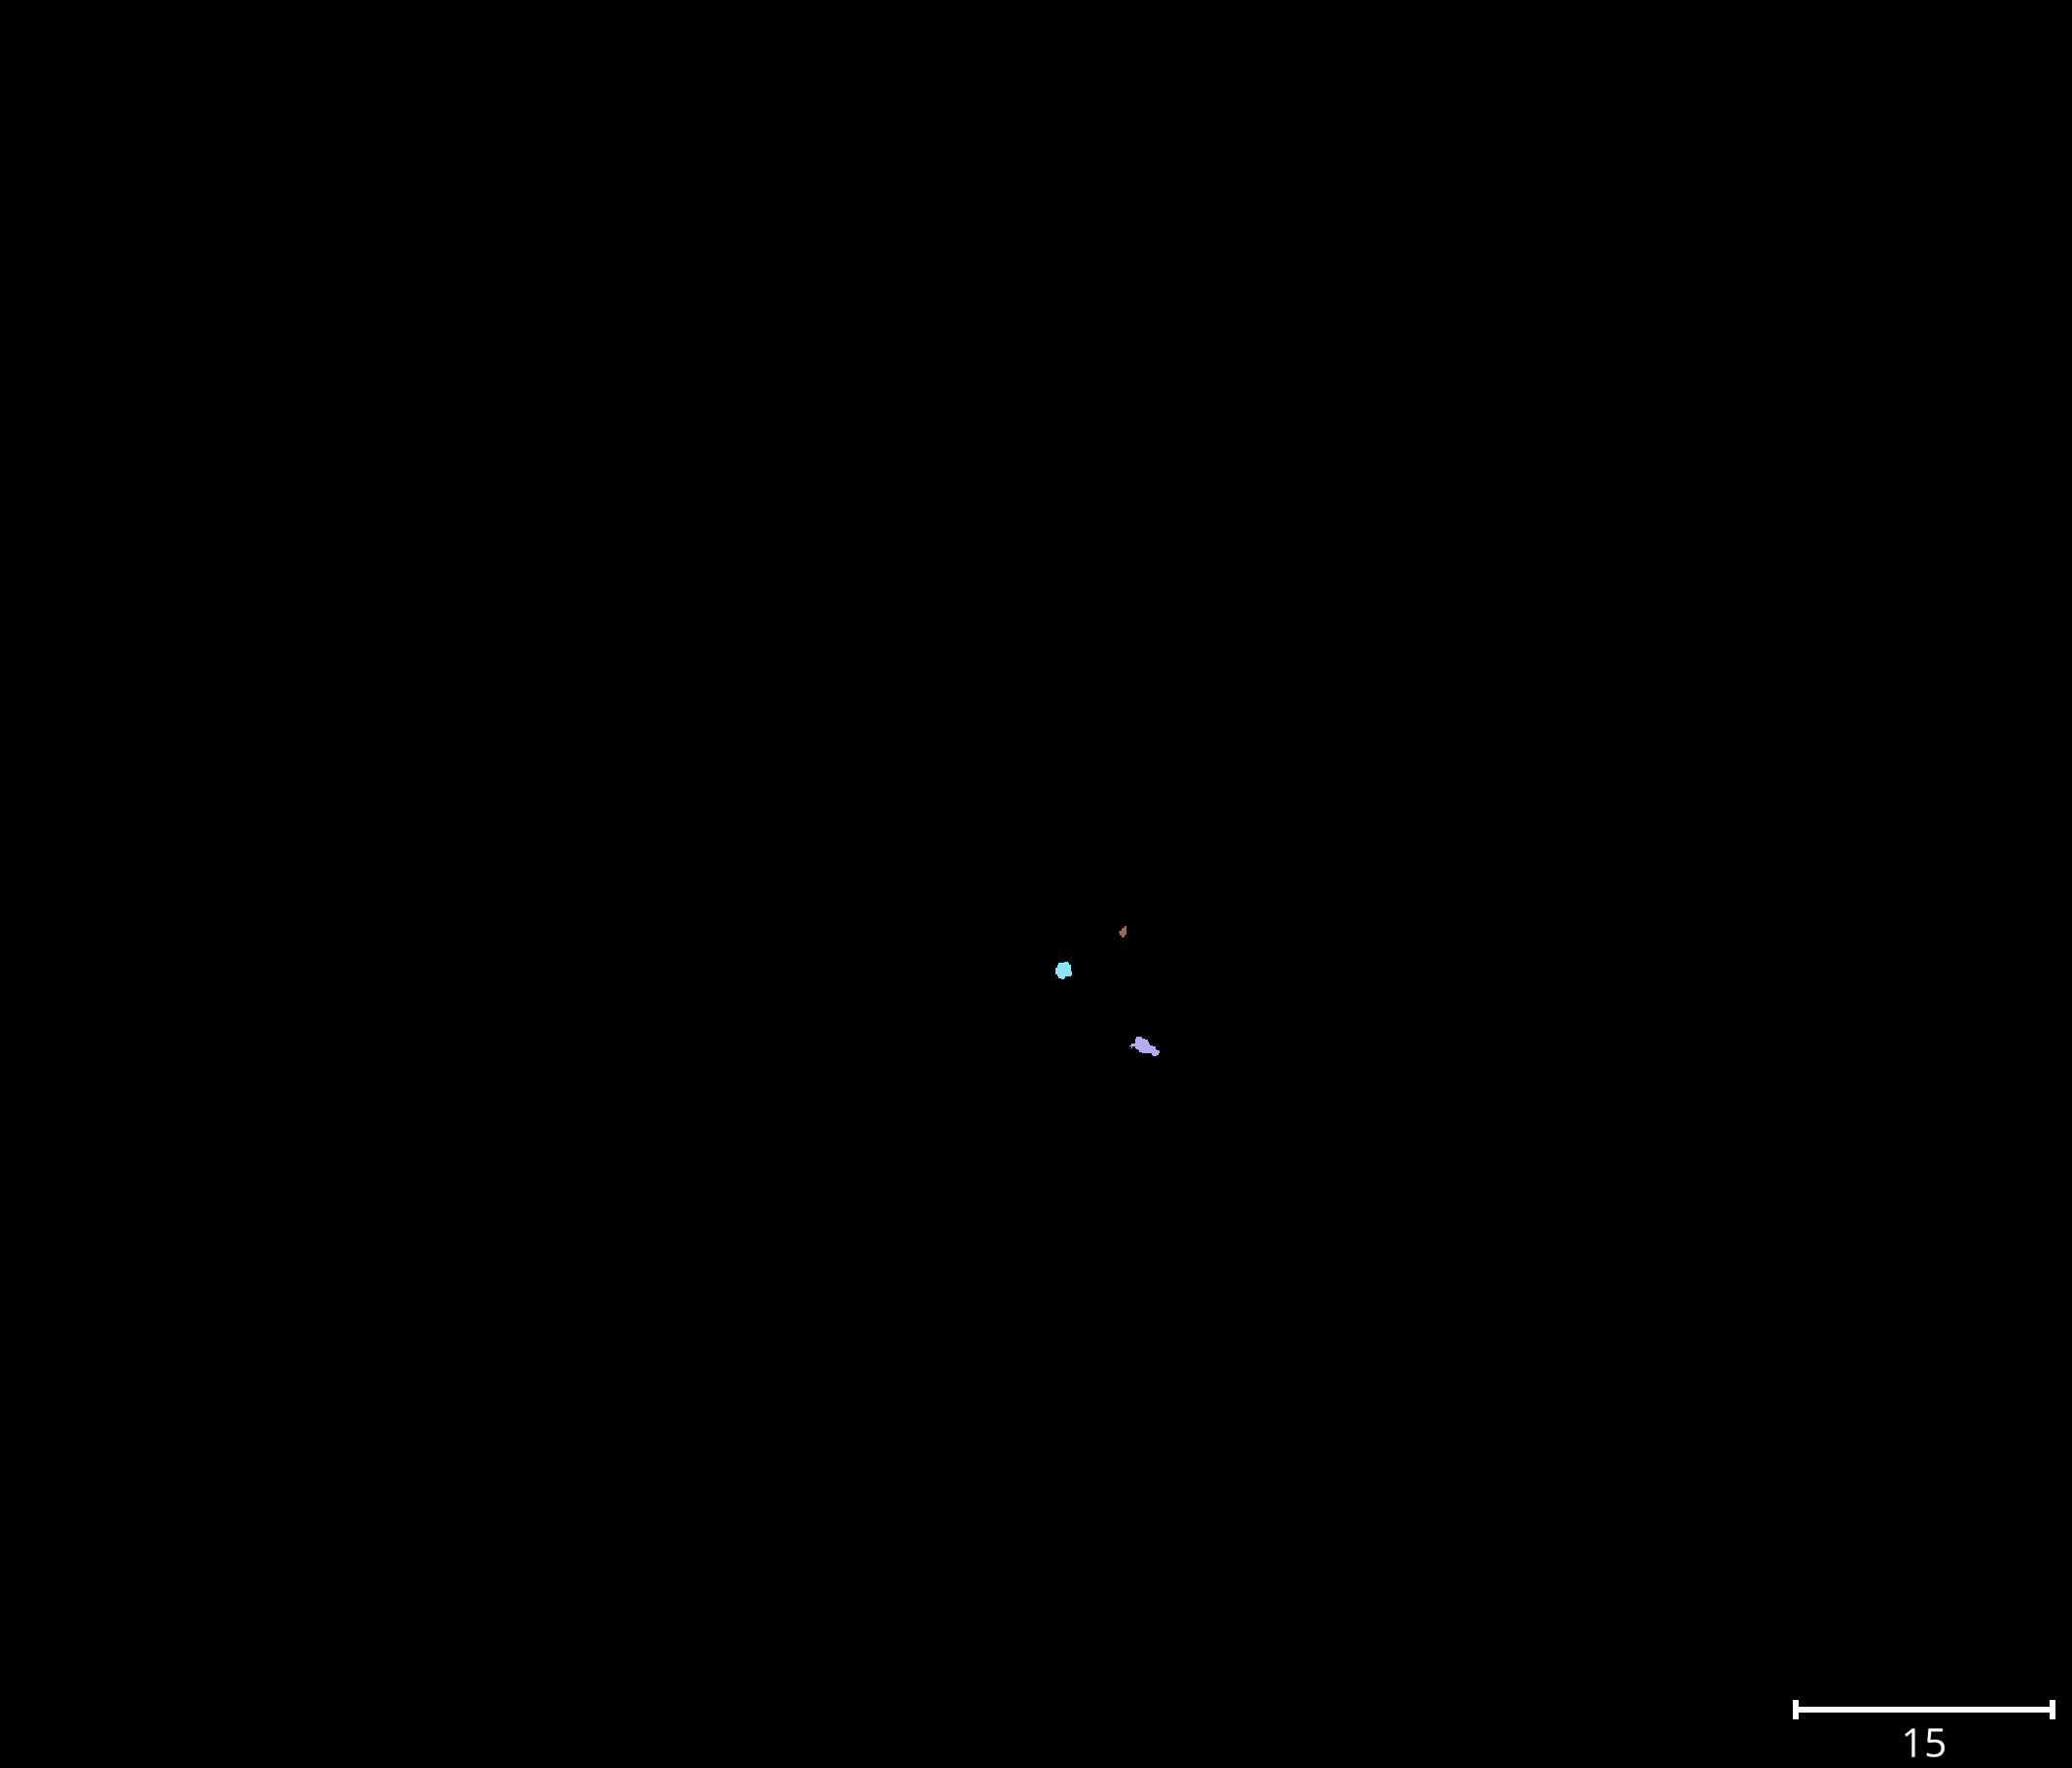

In [41]:
from napari.utils.notebook_display import nbscreenshot

# viewer.dims.ndisplay = 3
# viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer, canvas_only=True)